In [1]:
import torch
import os
import argparse
from tqdm import tqdm
from prefetch_generator import BackgroundGenerator
import easydict

import sys
sys.path.append(os.path.dirname(os.getcwd()).replace("/registration", ""))
import config as cfg
cfg.BENCHMARK = True
from environment import environment as env
from environment import transformations as tra
from registration.model import Agent
import registration.model as util_model
import utility.metrics as metrics
from utility.visualization_custom import CloudVisualizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
def evaluate(agent, test_loader, dataset_name, bop_results_path="", visualize=False):
    if visualize:
        if dataset_name != "lm":
            vis = CloudVisualizer(0.01)
        else:
            vis = OutlineVisualizer("lm", list(range(1, 16)), 0.01)
            obj_idx = 0

    agent.eval()
    progress = tqdm(BackgroundGenerator(test_loader), total=len(test_loader))

    if bop_results_path != "" and os.path.exists(bop_results_path):
        open(bop_results_path, 'w').write("")  # BOP toolkit expects file to contain results of a single evaluation run

    predictions = []
    with torch.no_grad():
        for data in progress:
            source, target, pose_source, pose_target = env.init(data)
            current_source = source

            if visualize:
                if dataset_name == "lm":
                    rgb = test_loader.dataset.get_rgb(int(data['scene'][obj_idx]), int(data['frame'][obj_idx]))
                     vis.reset(data, rgb, split="test")
                else:
                    vis.reset(source[0, :, :3].cpu().numpy(), target[0, :, :3].cpu().numpy(),
                              current_source[0, :, :3].cpu().numpy())
                    vis.update(current_source[0, :, :3].cpu().numpy())

            for step in range(cfg.ITER_EVAL):
                if cfg.BENCHMARK:
                    # re-use target embedding from first step (faster)
                    state_emb, action_logit, state_value, target = agent(current_source, target)
                else:
                    state_emb, action_logit, state_value, _ = agent(current_source, target)
                actions = util_model.action_from_logits(action_logit, deterministic=True)
                current_source, pose_source = env.step(source, actions, pose_source, cfg.DISENTANGLED)

                if visualize:
                    if dataset_name == "lm":
                        vis.update(tra.to_global(pose_source.clone(), source).cpu())
                    else:
                        vis.update(current_source[0, :, :3].cpu().numpy())
            if cfg.DISENTANGLED:
                pose_source = tra.to_global(pose_source, source)

            if dataset_name == "lm":
                # undo normalization
                predictions_unnorm = pose_source.clone().cpu()
                predictions_unnorm[:, :3, 3] *= data['normalization'][:, 0, 0][:, None]
                # apply refinement to initial estimate to get the full model-to-camera estimation
                #   note: prediction is from initial pose to model space
                init_i2c = data['est']
                prediction_m2i = torch.eye(4, device="cpu").repeat(pose_source.shape[0], 1, 1)
                prediction_m2i[:, :3, :3] = predictions_unnorm[:, :3, :3].transpose(2, 1)
                prediction_m2i[:, :3, 3] = -(prediction_m2i[:, :3, :3] @ predictions_unnorm[:, :3, 3].view(-1, 3, 1))\
                    .squeeze()
                estimates_m2c = init_i2c @ prediction_m2i
                # save in BOP format
                estimates_bop = ""
                for i_est, estimate in enumerate(estimates_m2c):
                    scene_id, im_id, obj_id = data['scene'][i_est], data['frame'][i_est],\
                                              data['gt']['obj_id'][i_est]
                    conf, duration = 1.0, 0.0  # no confidence estimated, duration would need to be for single frame
                    estimates_bop += f"{scene_id},{im_id},{obj_id},{conf:0.3f}," \
                                     f"{' '.join([f'{float(v):0.6f}' for v in estimate[:3, :3].reshape(-1)])}," \
                                     f"{' '.join([f'{float(v):0.6f}' for v in estimate[:3, 3].reshape(-1)])}," \
                                     f"{duration:0.3f}\n"
                with open(bop_results_path, 'a') as file:
                    file.write(estimates_bop)
            else:
                predictions.append(pose_source)
            #print(pose_source)

    # COMPUTE STATISTICS
    if dataset_name == "lm":
        print(f"Stored predictions in BOP format to {bop_results_path}.")
    else:
        predictions = torch.cat(predictions) # contains transformation matrix
        print(predictions)
        eval_metrics, summary_metrics = metrics.compute_stats(predictions, data_loader=test_loader)

        # log test metrics
        print(f"MAE R: {summary_metrics['r_mae']:0.2f}")
        print(f"MAE t: {summary_metrics['t_mae']:0.3f}")
        print(f"ISO R: {summary_metrics['r_iso']:0.2f}")
        print(f"ISO t: {summary_metrics['t_iso']:0.3f}")
        print(f"ADI AUC: {(summary_metrics['adi_auc10'] * 100):0.1f}%")
        print(f"CD: {summary_metrics['chamfer_dist'] * 1000:0.2f}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


  0%|          | 0/10 [00:00<?, ?it/s]

  loading weights...


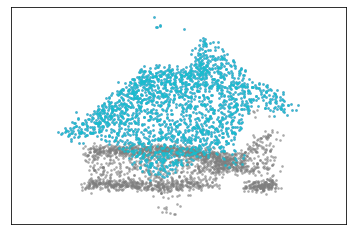

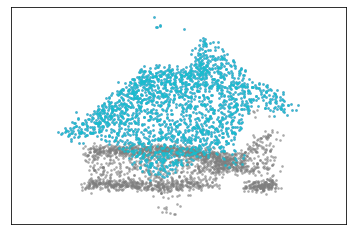

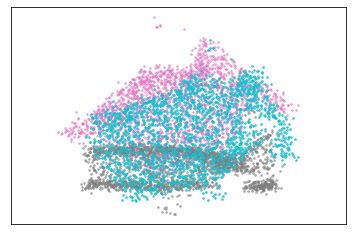

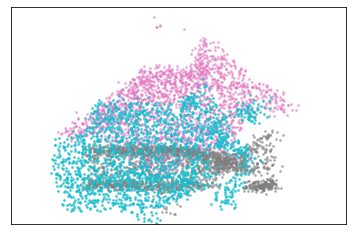

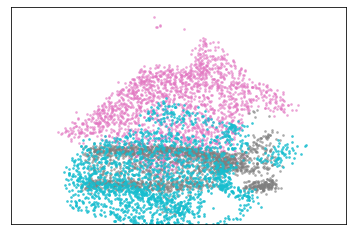

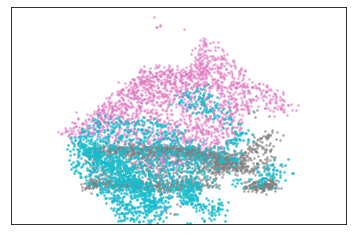

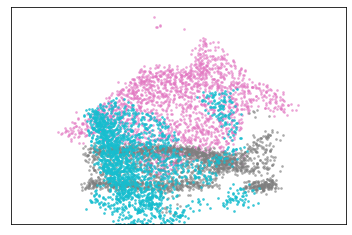

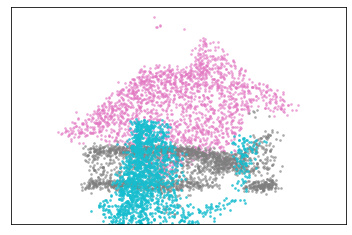

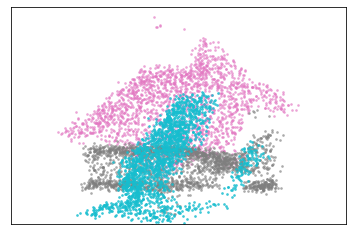

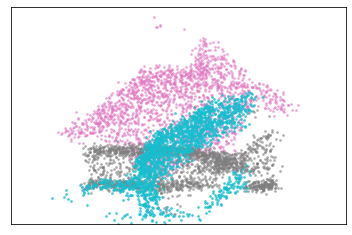

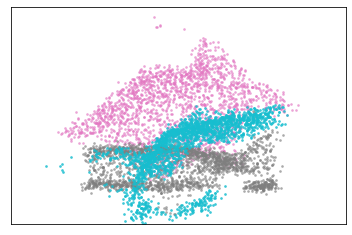

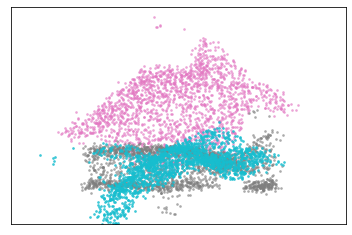

 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

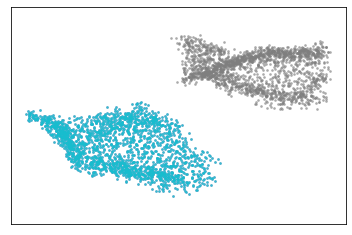

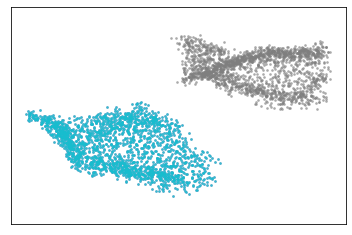

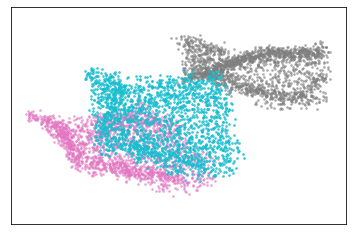

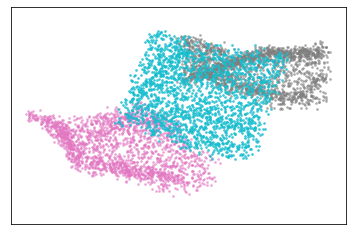

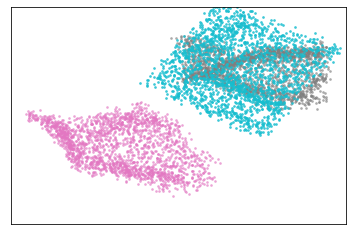

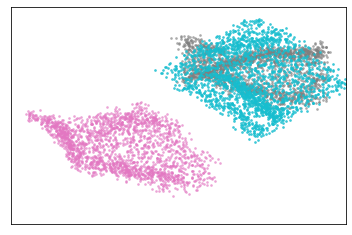

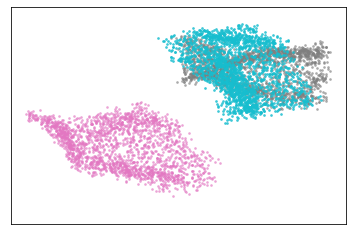

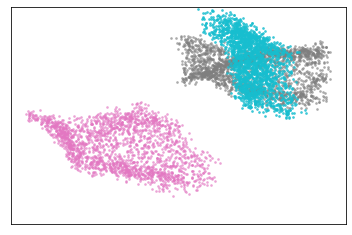

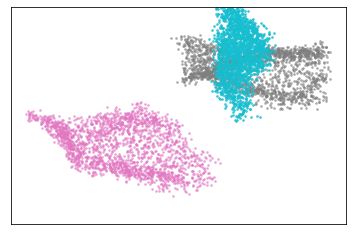

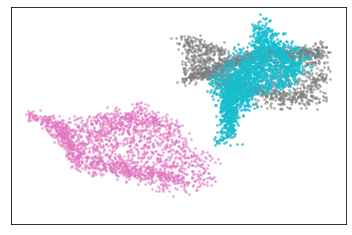

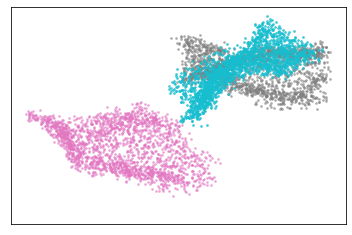

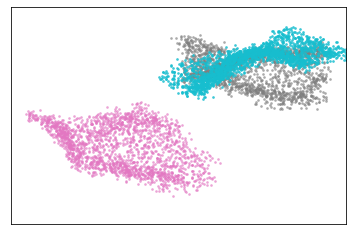

 20%|██        | 2/10 [00:02<00:08,  1.12s/it]

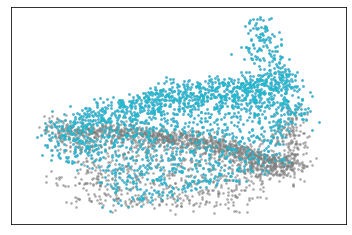

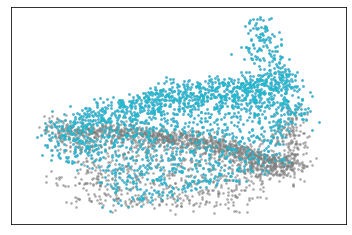

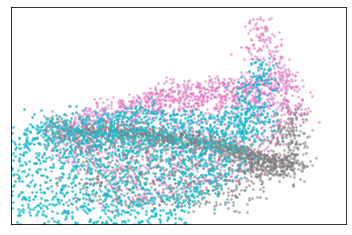

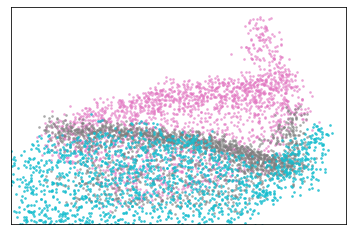

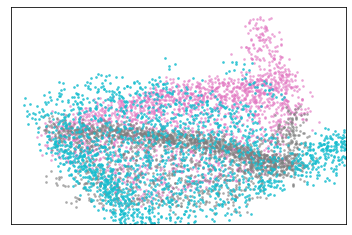

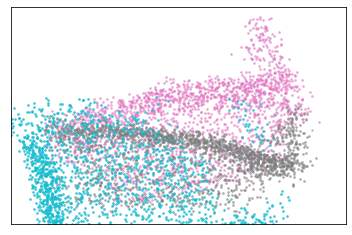

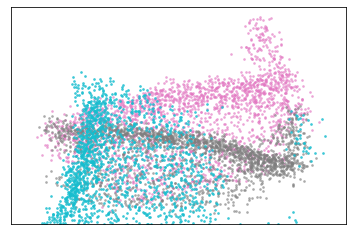

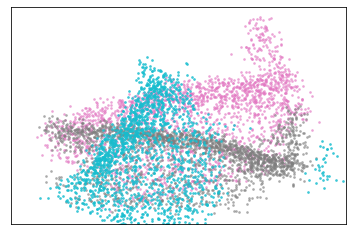

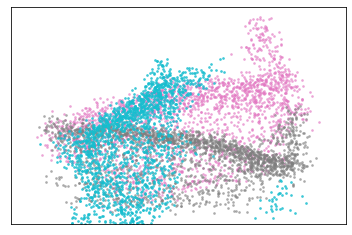

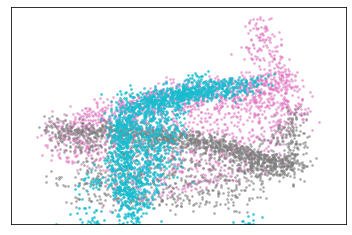

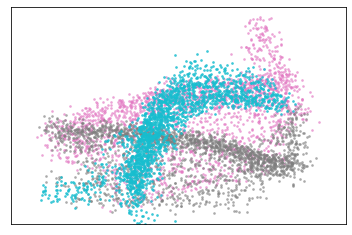

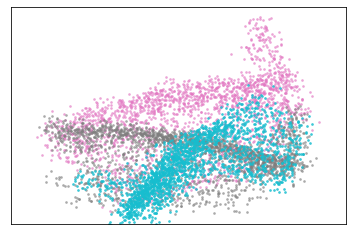

 30%|███       | 3/10 [00:03<00:08,  1.15s/it]

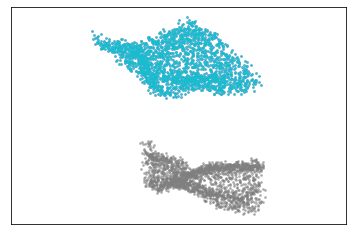

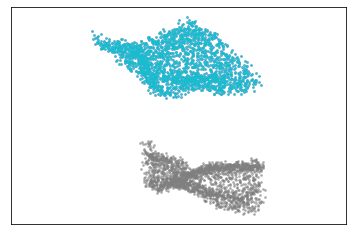

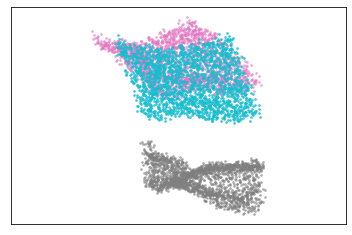

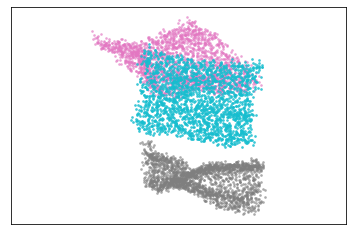

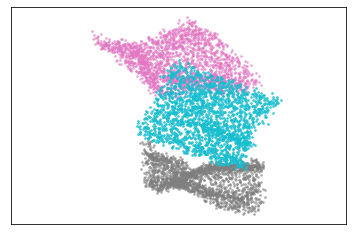

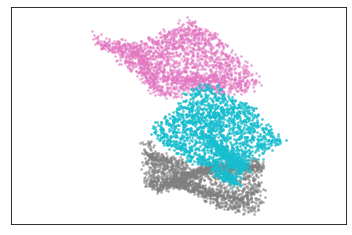

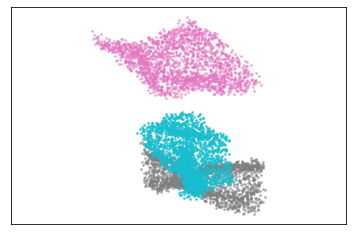

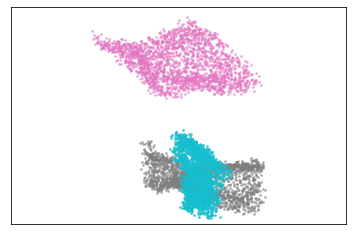

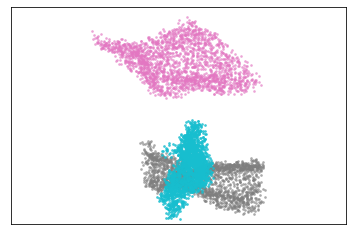

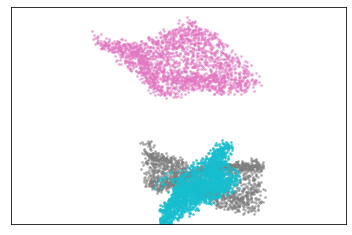

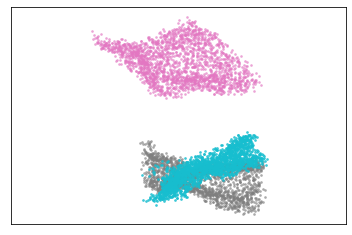

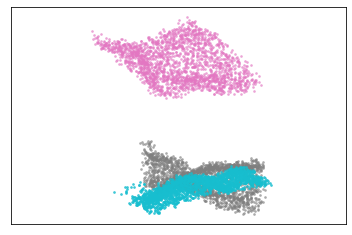

 40%|████      | 4/10 [00:04<00:06,  1.13s/it]

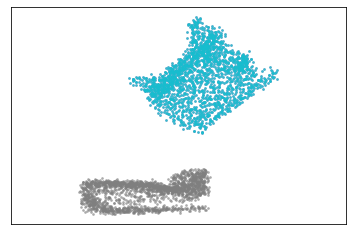

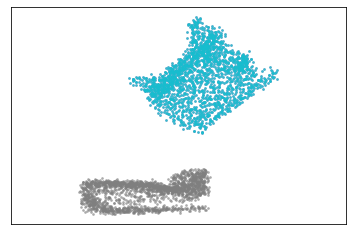

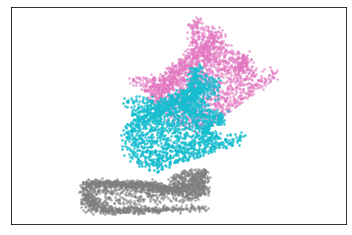

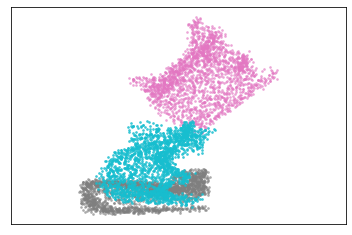

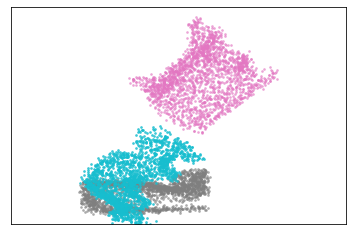

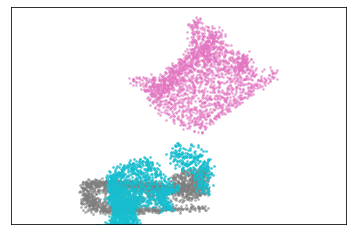

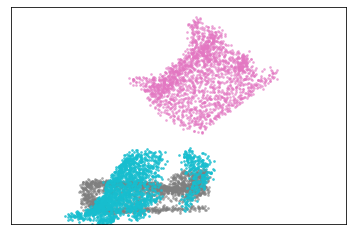

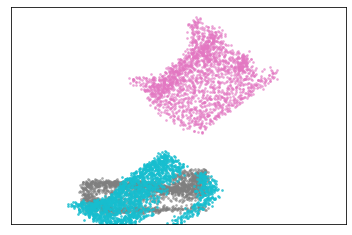

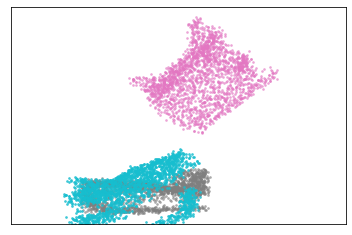

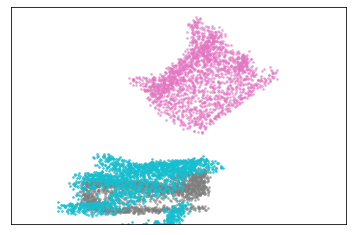

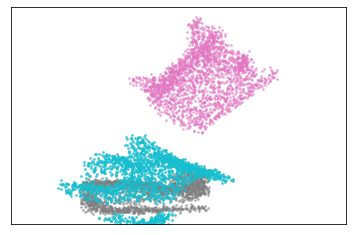

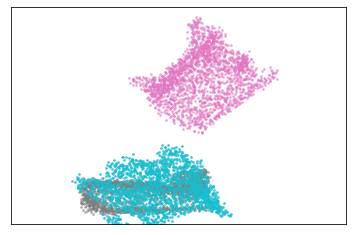

 50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

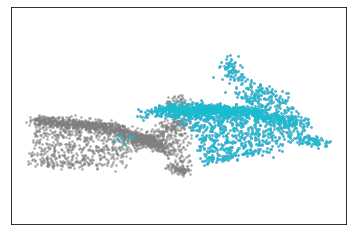

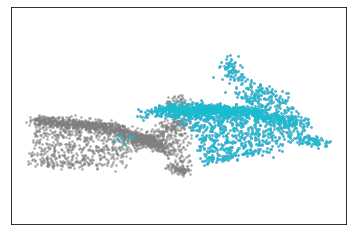

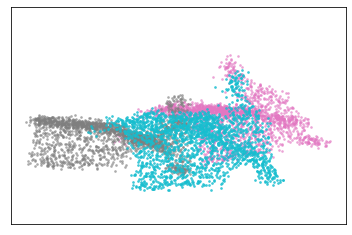

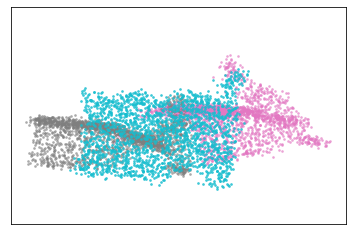

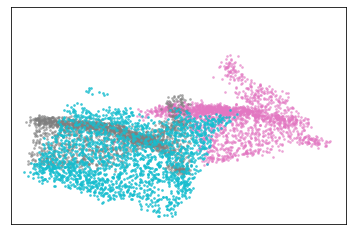

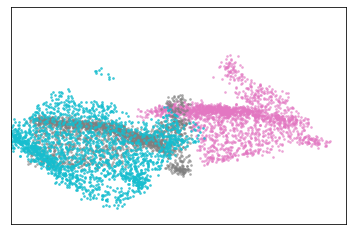

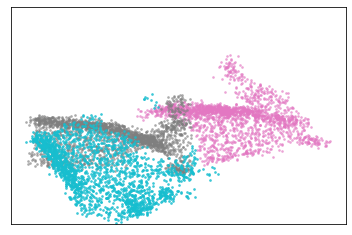

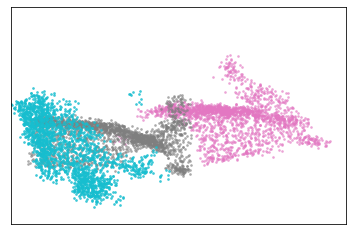

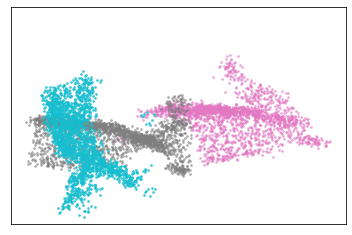

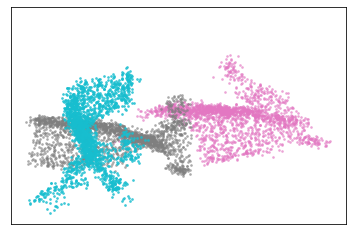

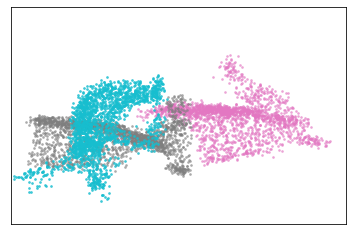

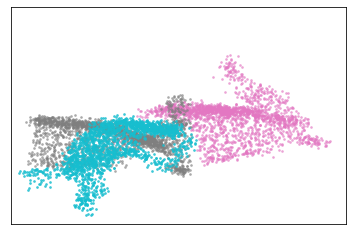

 60%|██████    | 6/10 [00:06<00:04,  1.11s/it]

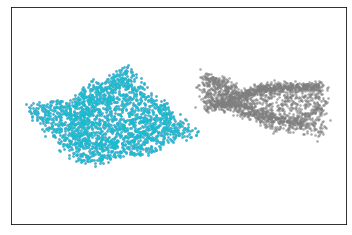

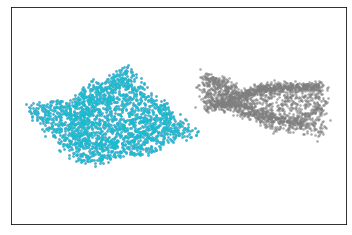

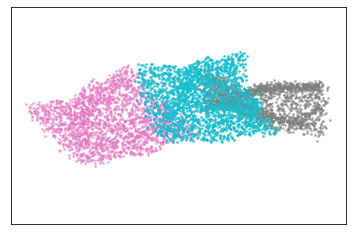

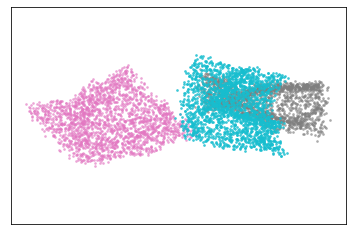

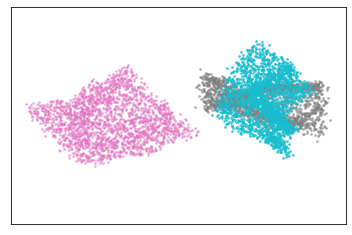

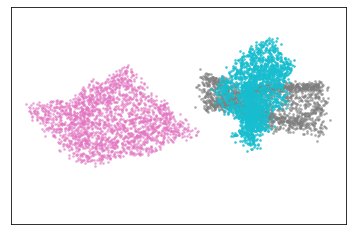

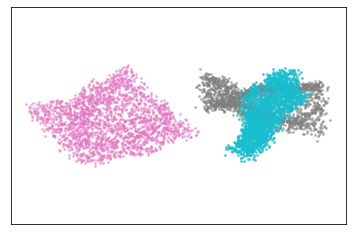

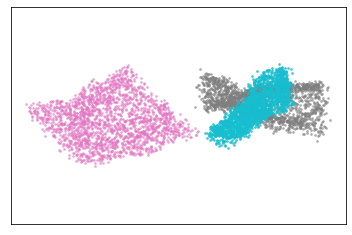

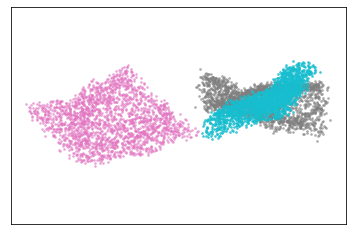

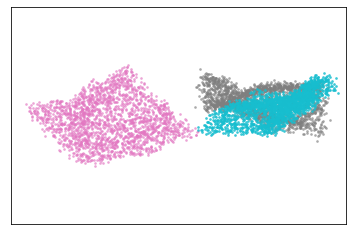

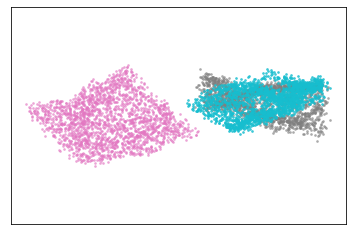

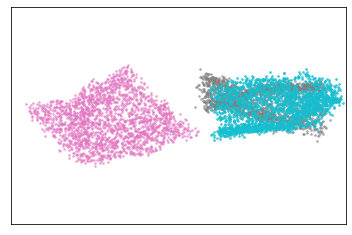

 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

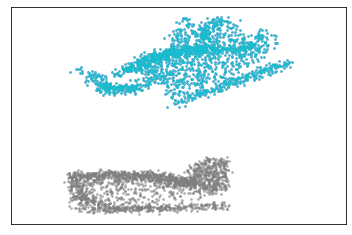

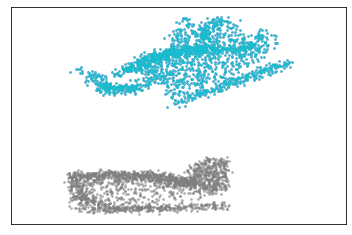

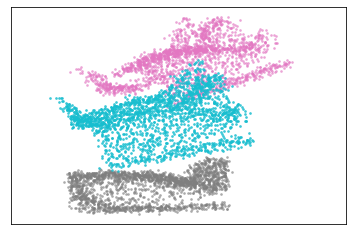

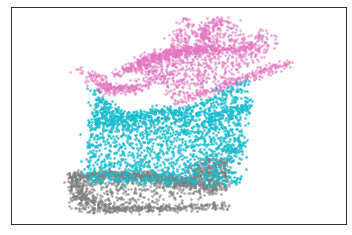

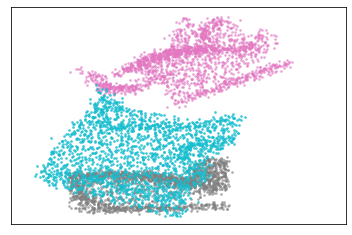

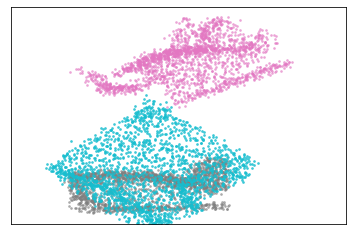

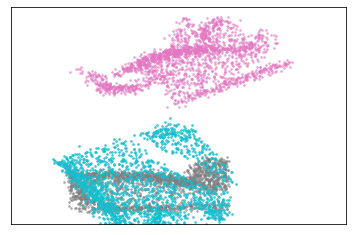

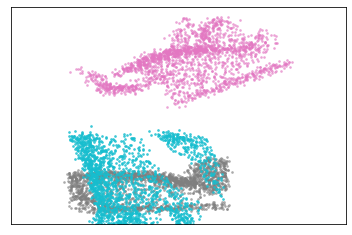

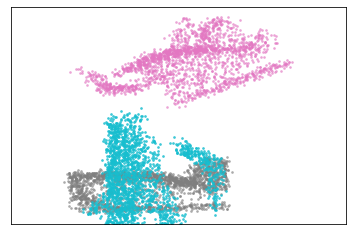

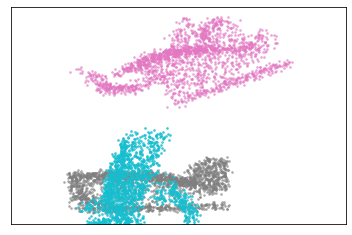

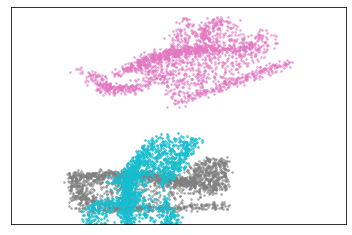

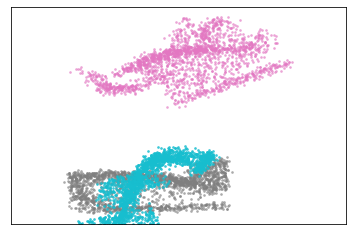

 80%|████████  | 8/10 [00:08<00:02,  1.09s/it]

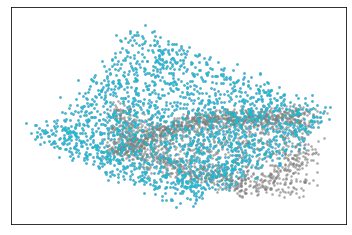

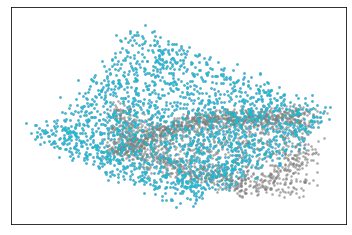

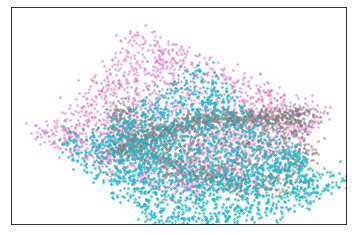

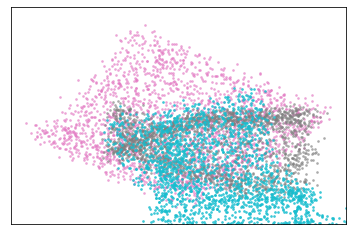

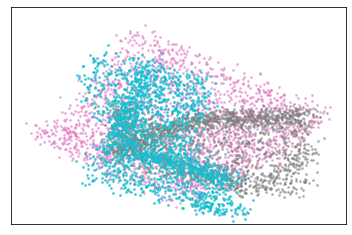

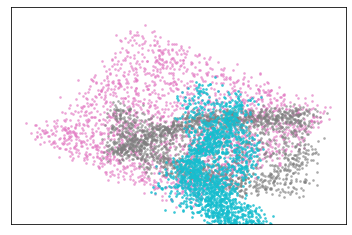

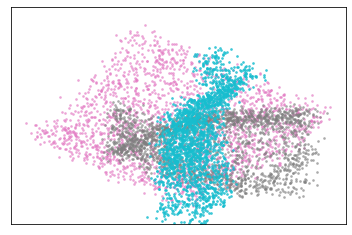

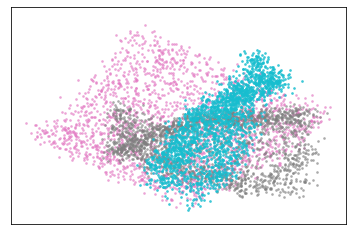

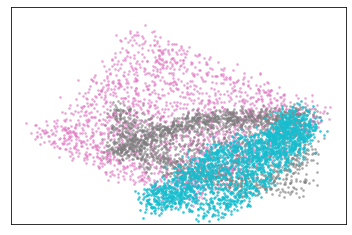

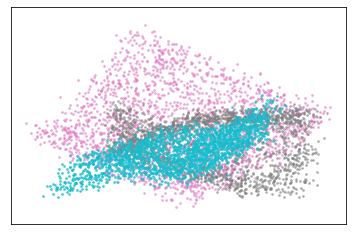

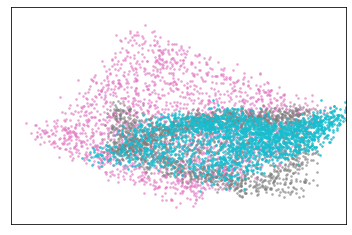

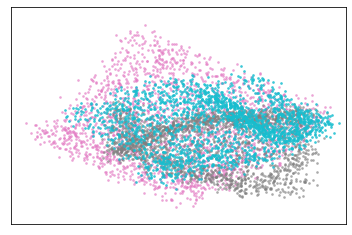

 90%|█████████ | 9/10 [00:10<00:01,  1.10s/it]

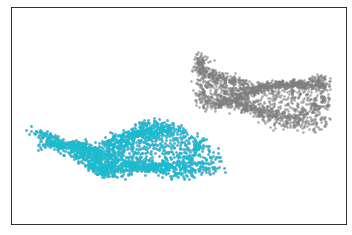

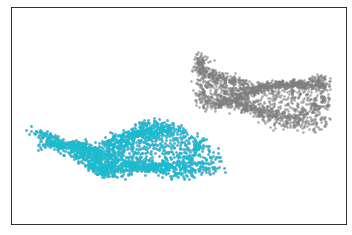

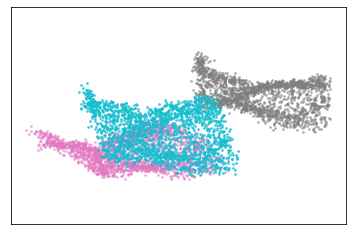

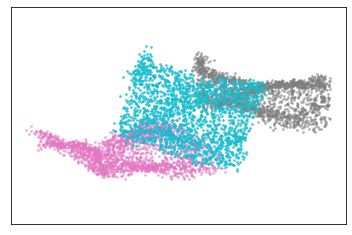

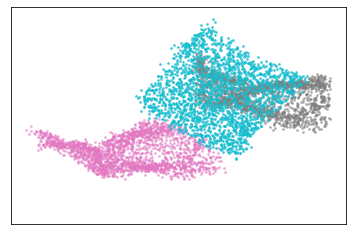

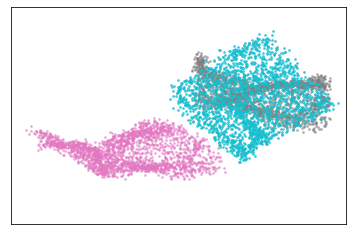

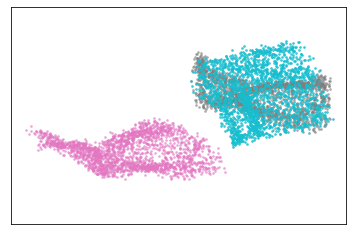

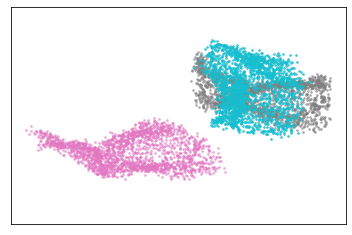

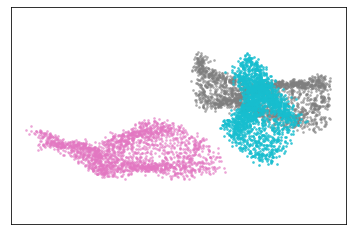

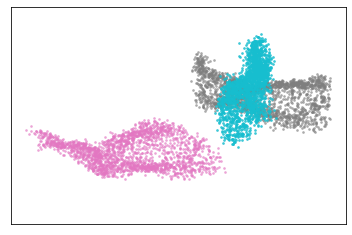

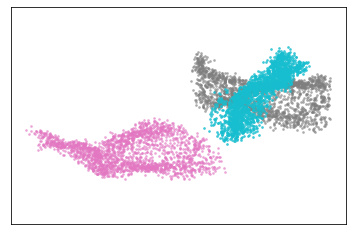

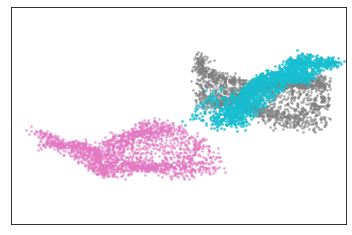

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]
                                      

tensor([[[ 0.4832, -0.8641,  0.1407,  0.0977],
         [ 0.3661,  0.3453,  0.8641, -0.1586],
         [-0.7953, -0.3661,  0.4832, -0.0242],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4832, -0.8641,  0.1407, -0.0763],
         [ 0.3661,  0.3453,  0.8641,  0.6284],
         [-0.7953, -0.3661,  0.4832, -0.0862],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4832, -0.8641,  0.1407,  0.0508],
         [ 0.3661,  0.3453,  0.8641,  0.0162],
         [-0.7953, -0.3661,  0.4832,  0.1272],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4832, -0.8641,  0.1407,  0.4201],
         [ 0.3661,  0.3453,  0.8641, -0.4797],
         [-0.7953, -0.3661,  0.4832,  0.0285],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4832, -0.8641,  0.1407,  0.5044],
         [ 0.3661,  0.3453,  0.8641, -0.1371],
         [-0.7953, -0.3661,  0.4832,  0.6009],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.4832, -0.8641,  0.1407, -0.1435],
   

In [4]:
if __name__ == '__main__':
    
    args = easydict.EasyDict({'mode': 'ilrl',
                             'dataset': 'Custom',
                             'batch_size': 1,
                             'visualize': True})

    code_path = os.path.dirname(os.getcwd()).replace("/registration", "")
    if args.dataset.startswith("Custom"):
        from dataset.dataset_custom import CustomDataset
        test_dataset = CustomDataset("test", "jitter")
        pretrain = os.path.join(code_path, f"weights/Custom_{args.mode}.zip")  # same weights for M40 and SON
        bop_results_path = ""
    
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    print("  loading weights...")
    agent = Agent().to(DEVICE)
    if os.path.exists(pretrain):
        util_model.load(agent, pretrain)
    else:
        raise FileNotFoundError(f"No weights found at {pretrain}. Download pretrained weights or run training first.")

    evaluate(agent, test_loader, args.dataset, bop_results_path, args.visualize)